***
The task is to conduct experiments with simulation training: watch what behavior cloning is and understand the DAgger algorithm.

Instead of a human demonstrator, demonstrations will be given by a special pre-trained “expert” start-up. The task is to implement the cloning algorithm and DAgger, to compare their performance on several simple management tasks from the OpenAI Gym package.
***

## Requirements:
### 1. __TensorFlow:__
 https://www.tensorflow.org/get_started/os_setup.
### 2. __OpenAI Gym:__  
https://gym.openai.com/docs v 0.10.5.
### 3. __MuJoCo:__<br>
v 1.50 – http://mujoco.org/

v 1.50.1.56 – https://github.com/openai/mujoco-py/
***

Imports

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

from tensorflow import layers

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


TensorFlow version : 1.12.0
Gym version : 0.11.0


***
## Statistics aggregation

We generate statistics (roll-outs) for a given expert strategy in 3 steps:
  1. Download the strategy from the file and initialize the environment.
  2. Begin the tensorflow session.
  3. As part of the session, collect data: until the end of the episode in the cycle, select the expert action, apply it and save the results.

In [2]:
#choose environment (Uncomment choosed one)
env_name="Humanoid-v2"
# env_name="Ant-v2"
# env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

# choose expert policy file from /expert file
expert_policy_file="experts/"+env_name+".pkl"

# load the policy
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# make the environment
env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts, max_steps, policy, env, render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)


        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
loaded and built


Testing the implemented function: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [3]:
generate_rollouts(num_rollouts=10, max_steps=200, policy=policy_fn, env=env, render=True);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw


***
## 1. Cloning behavior

Behavioural cloning (BC) is a method by which a computer program is trained to reproduce the actions of an expert (person). The expert’s actions are recorded, and then these statistics are used as input to the learning algorithm. This algorithm as a result forms a sequence of actions by which the behavior of the expert is reproduced.

We will use standard training with a teacher and use a neural network for this.

In [1]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_expert - self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        l_1 = layers.dense(inputs=input_placeholder, units=self.output_data.shape[1])
        l_2 = layers.dropout(inputs=l_1, rate=0.7)
        l_3 = layers.batch_normalization(inputs=l_2)
        l_4 = layers.dense(inputs=l_3, units=self.output_data.shape[1])
        return l_3

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Let's train the model on expert data

In [5]:
# generate expert data
data = generate_rollouts(num_rollouts=50, max_steps=1000, policy=policy_fn, env=env, render=False);
x = data['observations']
y = data['actions']

# shuffle data
x, y = shuffle(x, y)

# create an object from BC_Model class, and train it
cloner = BC_Model(x, y)
cloner.train()

### Test model

In [6]:
def test_model(cloner, num_eval_rollouts, env=None, render=False):
    # loop over runouts
    returns = []
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr = 0
        done = False
        obs = env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action = cloner.sample(obs)
            # implement the action
            obs, r, done, _ = env.step(action)
            if render:
                env.render()
            totalr += r
        returns.append(totalr)
    return returns

rewards = test_model(cloner, 50, env)

We will train the model on any three MoJoCo environments and Build returns graphs (totalr) depending on the number of statistics collected (num_rollouts) for training.

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

Ant-v2


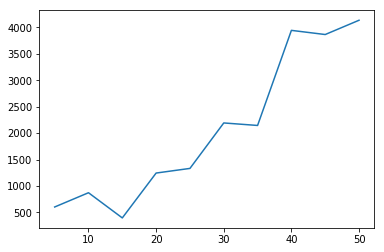

Humanoid-v2


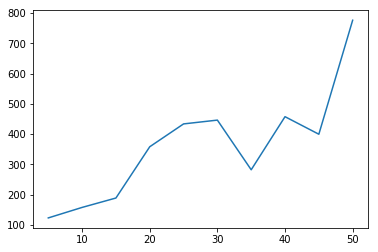

HalfCheetah-v2


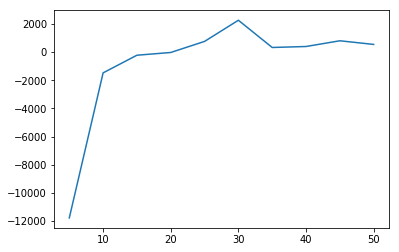

In [14]:
env_names = ["Ant-v2", "Humanoid-v2", "HalfCheetah-v2"]

for env_name in env_names:
    
    print(env_name)
    
    rollouts = []
    totalrs = []
    
    for num_rollouts in range(5, 51, 5):

        rollouts.append(num_rollouts)

        env = gym.make(env_name)
        
        expert_policy_file = "experts/" + env_name + ".pkl"
        
        # load the policy
        policy_fn = load_policy.load_policy(expert_policy_file)
        
        data = generate_rollouts(50, max_steps=500, policy=policy_fn, env=env, render=False)

        x = data['observations']
        y = data['actions']

        # shuffle data
        x, y = shuffle(x, y)

        # create an object from BC_Model class, and train it
        cloner = BC_Model(x, y)
        cloner.train()
        
        rewards = test_model(cloner, num_rollouts, env)
        
        totalrs.append(sum(rewards) / len(rewards))
    
    plt.plot(rollouts, totalrs)
    plt.show()
    

The following pattern is visible on the charts for Ant-v2 and Humanoid-v2: an increase in the number of rollouts gives the best result.

We will choose one of the hyperameter of our model, which affect the quality of training. For one of the environments, we construct a graph of the influence of the value of this parameter on the quality of education (totalr).

3
6
9
12
15
18
21
24
27


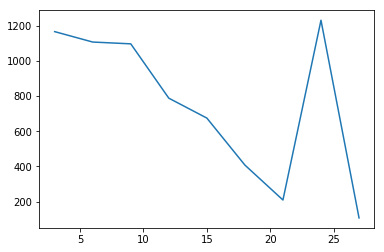

In [15]:
epoches_list = [i*3 for i in range(1, 10)]
totalrs = []

for epoches in epoches_list:
    print(epoches)
    cloner.train()
    returns = test_model(cloner, num_rollouts, env)
    totalrs.append(sum(returns) / len(returns))

plt.plot(epoches_list, totalrs)
plt.show()

***
## 2. DAgger Algorithm

The purpose of the DAgger algorithm (data Aggregation) is to collect statistics of the trained model, instead of expert data.
- First, we train BC_Model on the collected expert data.
- Run the model on the environment, collect observations.
- Then we ask the expert (person) to note what actions need to be performed in the observations received (in fact, we use __policy_fn__).
- Create a new collection of tagged and expert data.
- Let's do it.

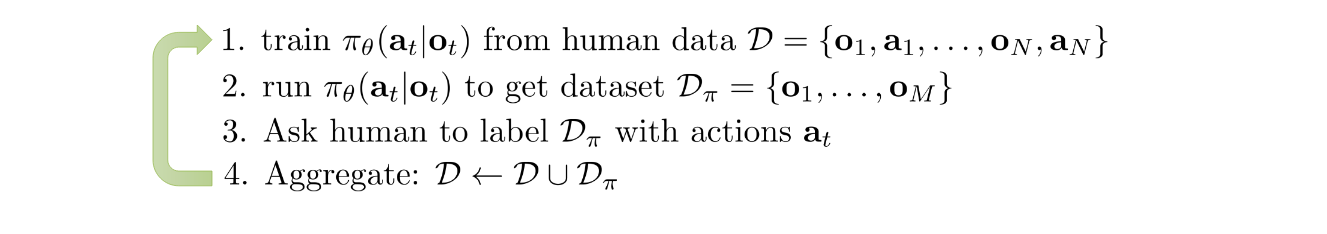

In [2]:
def train_dagger_model(x, y, policy_fn, env, cloner):
    with tf.Session():
        DAgger_iter = 10
        render = False
        # DAgger loop
        for i in range(DAgger_iter):
            # reset in each iteration
            new_obs = []
            new_actions = []
            obs = env.reset()
            done = False
            # collect data from model and expert
            while not done:
                # get an action from the model
                action=cloner.sample(obs)

                obs, _, done, _ = env.step(action)
                if render:
                    env.render()
                # get the expert action for the same input
                corrected_action = policy_fn(obs[None,:])

                # append the observation and expert action to the data set
                new_obs.append(obs)
                new_actions.append(corrected_action)
            # re-order the data
            for obs in new_obs:
                x = np.concatenate((x, obs[None, :]), axis = 0)
            for corrected_action in new_actions:
                y = np.concatenate((y, corrected_action[None, :]), axis = 0)
            # train the model on the collected data
            cloner.train(train_data=x, test_data=y)
        return cloner

### Check

In [ ]:
# cloner = train_dagger_model(x, y, policy_fn, env, cloner)
# rewards = test_model(cloner, 20, env=None, render=False)

Ant-v2
Standart model trained.
Dagger model trained.


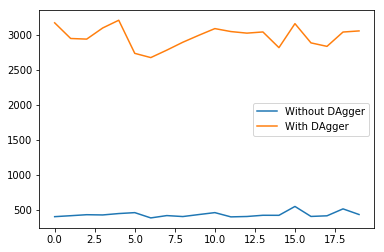

Humanoid-v2
Standart model trained.
Dagger model trained.


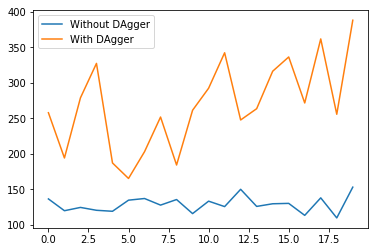

Reacher-v2
Standart model trained.
Dagger model trained.


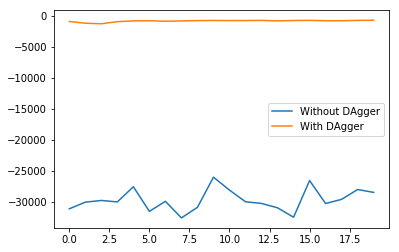

Walker2d-v2
Standart model trained.
Dagger model trained.


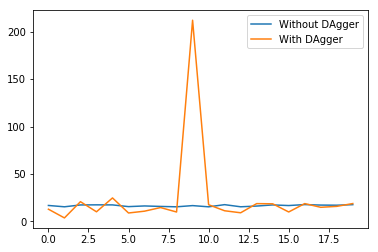

In [30]:
env_names = ["Ant-v2", "Humanoid-v2", "Reacher-v2", "Walker2d-v2"]

for env_name in env_names:
    
    print(env_name)
    
    env = gym.make(env_name)
    expert_policy_file = "experts/" + env_name + ".pkl"
    policy_fn = load_policy.load_policy(expert_policy_file)

    cloner = train_simple_model(policy_fn, env, num_rollouts=50)
    data = generate_rollouts(50, max_steps=100, policy=policy_fn, env=env, render=False)

    x = data['observations']
    y = data['actions']

    # shuffle data
    x, y = shuffle(x, y)
    cloner = BC_Model(x, y)
    cloner.train()
        
    rewards = test_model(cloner, num_eval_rollouts=50, env=env)
    print('Standart model trained.')
    
    dagger_cloner = train_dagger_model(x, y, policy_fn, env, cloner)
    dagger_rewards = test_model(cloner, num_eval_rollouts=50, env=env)
    print('Dagger model trained.')

    line_up, = plt.plot([i for i in range(len(rewards))], rewards, label='Without DAgger')
    line_down, = plt.plot([i for i in range(len(dagger_rewards))], dagger_rewards, label='With DAgger')
    plt.legend(handles=[line_up, line_down])
    plt.show()

It can be seen that the DAgger is  cool and gives boost to the quality :)